# **Trabalho Prático - Jardim Comunitário Raízes Vivas**
## Aprendizado de Máquina A
### **Professor(es):** Gisele Lobo Pappa e Lourenço Ribeiro Grossi Araújo
### **Aluno:** Bernardo Reis de Almeida

Este trabalho prático tem por objetivo a aplicação de todos os conhecimentos adquiridos ao decorrer do curso em uma tarefa real de análise e de modelagem preditiva. O problema a ser abordado trata-se de uma tarefa de predição no contexto de um jardim comunitário, denominado "Raízes Vivas". É de interesse dos proprietários desse jardim predizer se membros da comunidade irão manter uma participação ativa no projeto ou se haverá algum declínio no engajamento. A base de dados a ser utilizada é composta por vários atributos associados a cada membro do jardim, sendo a coluna alvo denominada "*support_outcome*", a qual, como já mencionado, descreve se o indivíduo em questão manteve um engajamento contínuo ou se houve uma queda em sua participação nas atividades do estabelecimento. Ao final, almeja-se a obtenção de um modelo capaz de predizer de maneira robusta o possível êxito de cada novo membro integrante do jardim, colaborando com a manutenção de um ambiente acolhedor e próspero.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
from torch import nn
from torch import optim

import optuna
from optuna.samplers import TPESampler

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/home/bereis01/Personal/UFMG/Projects/MLA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Análise Exploratória**

O primeiro passo neste trabalho de análise e modelagem preditiva consiste em uma análise exploratória dos dados. A ideia é adquirir uma compreensão mais a fundo de todas as suas facetas, incluindo, mas não restrito a, quais atributos estão disponíveis, qual é sua distribuição, se há valores faltantes, quais colunas são numéricas e quais são categóricas, dentre outras informações. Um entendimento completo da base de dados em mãos facilitará as etapas posteriores de escolha, treinamento, refinamento e utilização de modelos preditivos.

Os dados em si vêm em duas bases de dados, uma a ser utilizada para treinamento, contendo os rótulos, e uma a ser utilizada para testes, a qual não contém os rótulos reais de cada instância. Como a separação treino/teste já foi feita, no restante deste trabalho, a base de treino será dividida apenas para fins de validação e, ao final, será inteiramente utilizada para treinamento, com o objetivo de prever os rótulos da base de teste.

In [2]:
# Reading all the data from csv
df = pd.read_csv("dados/df_train.csv")

A seguir, são apresentadas informações básicas sobre os dados.

In [3]:
# Size of the database
df.shape

(800, 22)

In [4]:
# Names and types of the columns
df.dtypes

id                                 int64
garden_points_status              object
commitment_months                float64
participation_history             object
project_focus_code                object
requested_resources_value        float64
personal_reserve_status           object
volunteer_tenure_bracket          object
time_commitment_rate             float64
household_profile                 object
co_sponsor_presence               object
years_in_neighborhood_bracket    float64
asset_contribution_type           object
member_age                       float64
other_support_plans               object
housing_situation                 object
existing_commitments_count       float64
role_skill_tier                   object
dependents_supported             float64
has_phone                         object
newcomer_status                   object
support_outcome                   object
dtype: object

In [5]:
# Distribution of numeric values
df.describe()

,id,commitment_months,requested_resources_value,time_commitment_rate,years_in_neighborhood_bracket,member_age,existing_commitments_count,dependents_supported
count,800.000000,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000
mean,501.047500,20.770000,3189.59125,2.941250,2.83000,35.323750,1.407500,1.160000
std,287.802407,11.817325,2673.54737,1.124446,1.11137,11.045313,0.567315,0.366835
min,1.000000,4.000000,276.00000,1.000000,1.00000,19.000000,1.000000,1.000000
25%,252.750000,12.000000,1353.00000,2.000000,2.00000,27.000000,1.000000,1.000000
50%,496.500000,18.000000,2317.00000,3.000000,3.00000,33.000000,1.000000,1.000000
75%,749.250000,24.000000,3933.00000,4.000000,4.00000,41.000000,2.000000,1.000000
max,1000.000000,60.000000,15945.00000,4.000000,4.00000,75.000000,4.000000,2.000000


As distribuições das variáveis numéricas, apresentadas acima, revelam principalmente que alguns dos atributos estão descritos em escalas bem diferentes, o que pode ter impacto em alguns modelos, principalmente naqueles baseados em alguma noção de distância entre as instâncias. Dessa forma, nas etapas seguintes de pré-processamento dos dados, podem ser consideradas abordagens de normalização.

Além disso, nota-se que várias colunas apresentam valores categóricos que deverão ser codificados de alguma forma a depender do modelo escolhido, já que existem modelos, como redes neurais, que trabalham predominantemente, senão exclusivamente, com dados numéricos.

A fim de se ter uma compreensão melhor desses atributos categóricos, os quais não são capturados pela tabela apresentada anteriormente, a seguir, são apresentados os valores únicos de cada um deles e sua distribuição.

In [6]:
# Prints the name of the categorical attribute,
# the amount of possible values it can assume
# and the values by themselves
for column in df.columns:
    if df.dtypes[column] == "object":
        print(column, len(list(df[column].unique())))
        print(list(df[column].unique()))
        print()

garden_points_status 4
['Points negative', 'No points account', 'Points 0–199', 'Points 200+']

participation_history 5
['Previous roles completed', 'Issues on prior roles', 'All roles on time', 'No prior roles / all on time', 'Delayed in prior commitments']

project_focus_code 10
['Transport (used)', 'Communications equipment', 'Workshop equipment', 'Shared appliances', 'Transport (new)', 'Training / education', 'Retraining', 'Plot repairs', 'Other project', 'Microenterprise support']

personal_reserve_status 5
['No reserve', 'Reserve: <100', 'Reserve: 100–499', 'Reserve: ≥1000', 'Reserve: 500–999']

volunteer_tenure_bracket 5
['>=7', '1<=X<4', '<1', '4<=X<7', 'unemployed']

household_profile 4
['Single adult', 'Adult w/ dependents or shared household', 'Recently separated household', 'Committed/shared household']

co_sponsor_presence 3
['No co-sponsor', 'Mentor sponsor', 'Co-gardener sponsor']

asset_contribution_type 4
['No tangible assets', 'Shared tools', 'Long-term fund', 'Commun

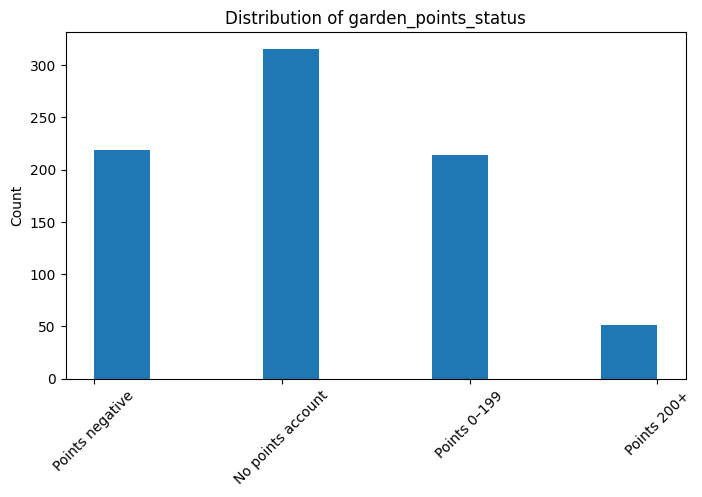

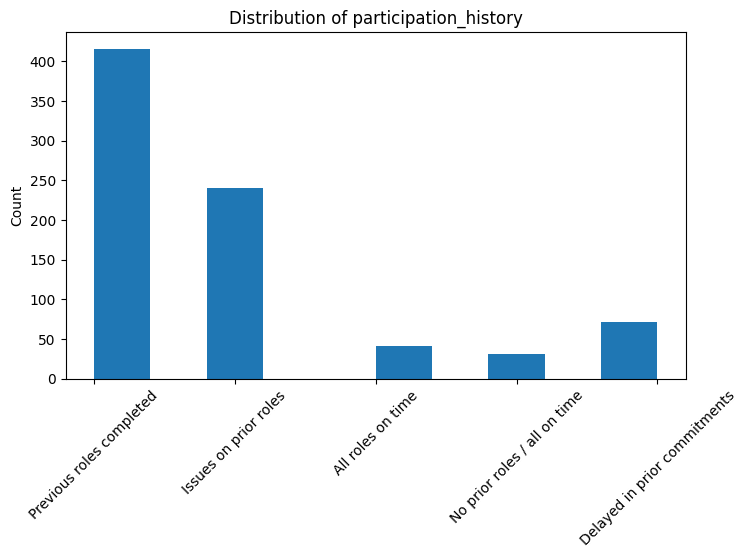

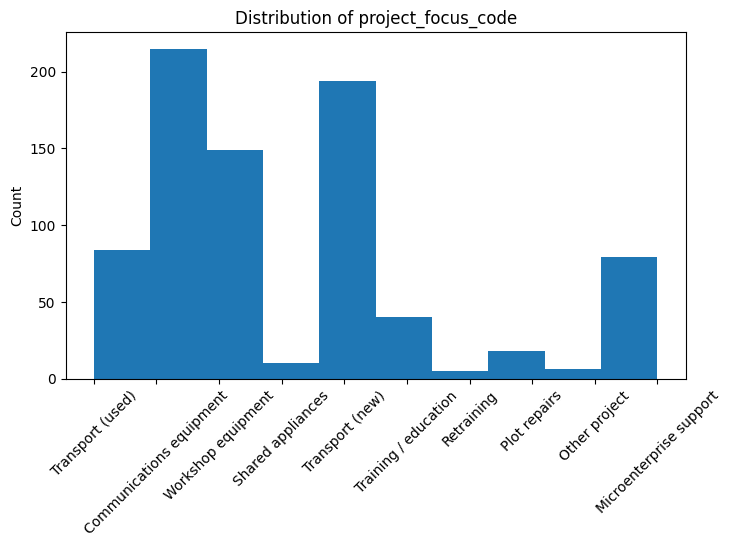

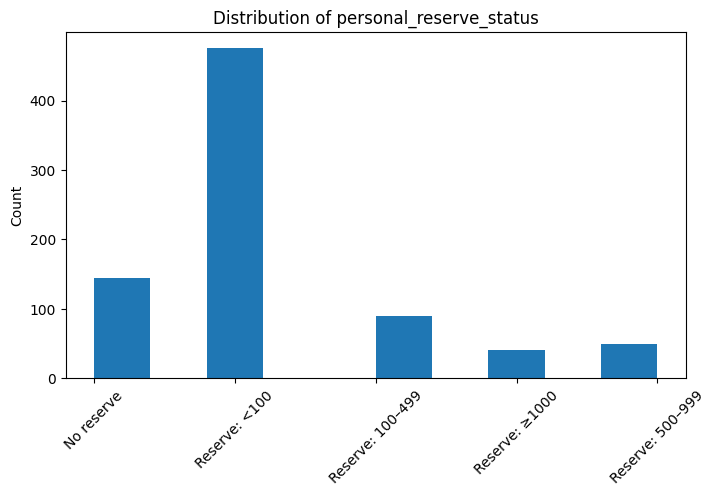

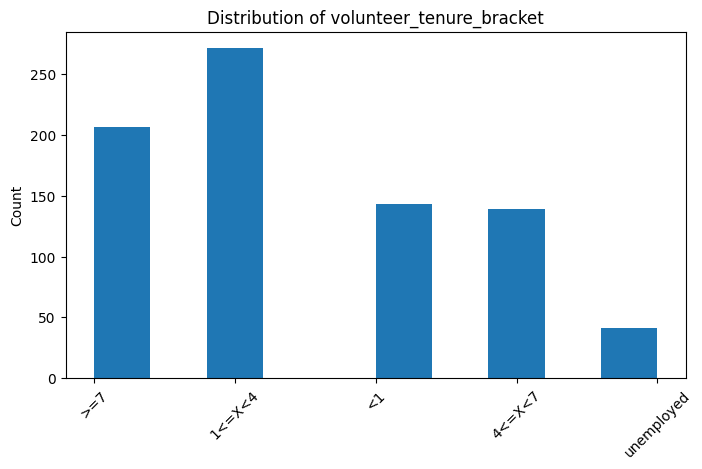

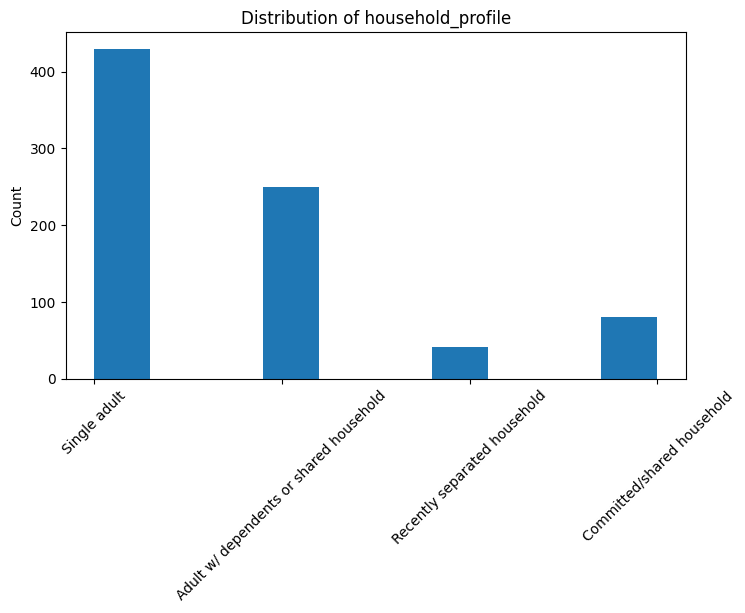

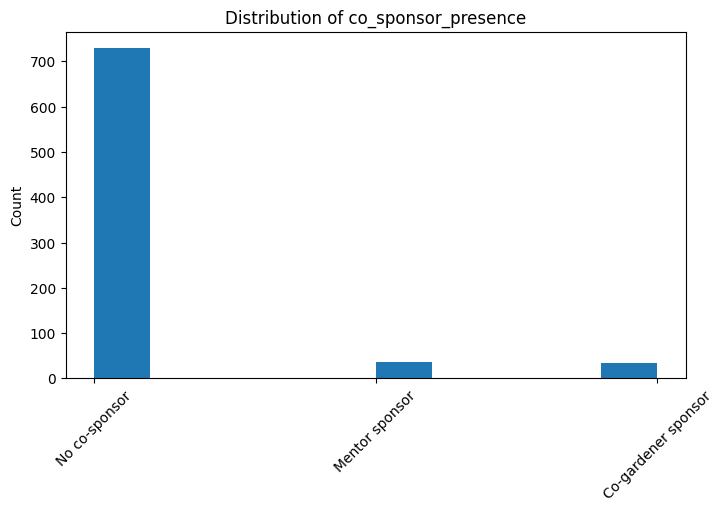

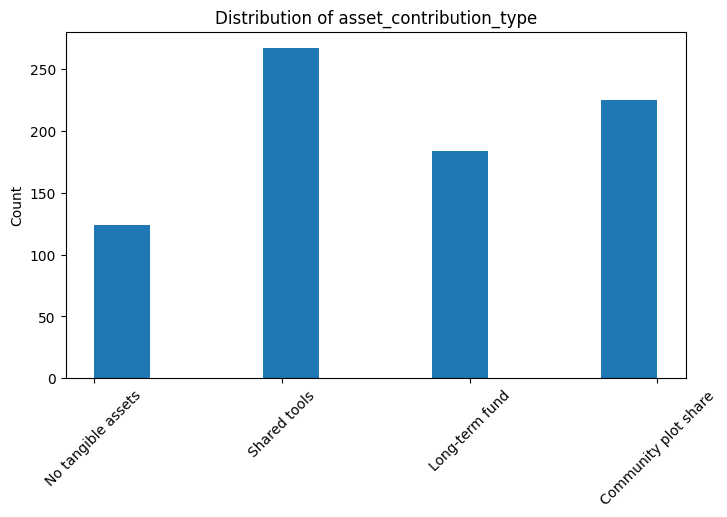

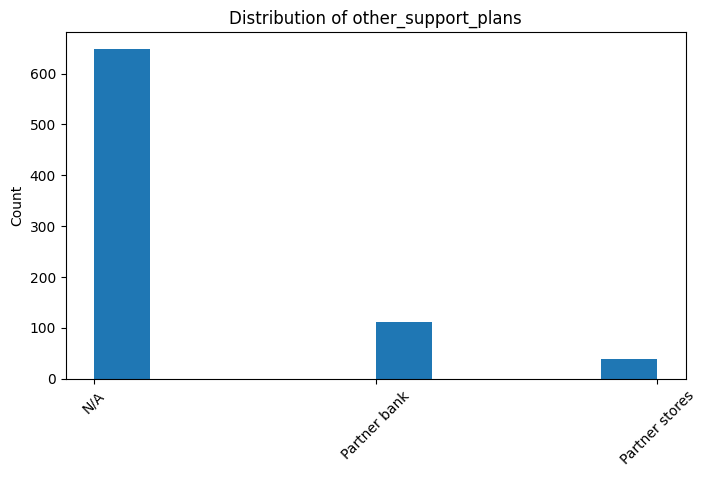

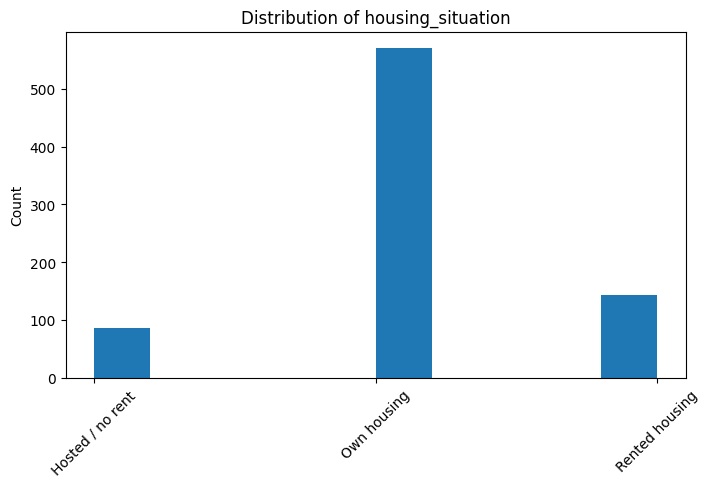

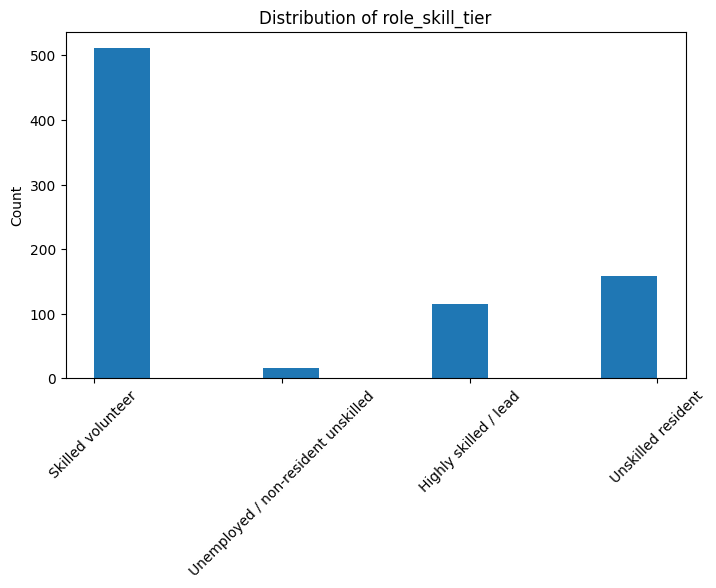

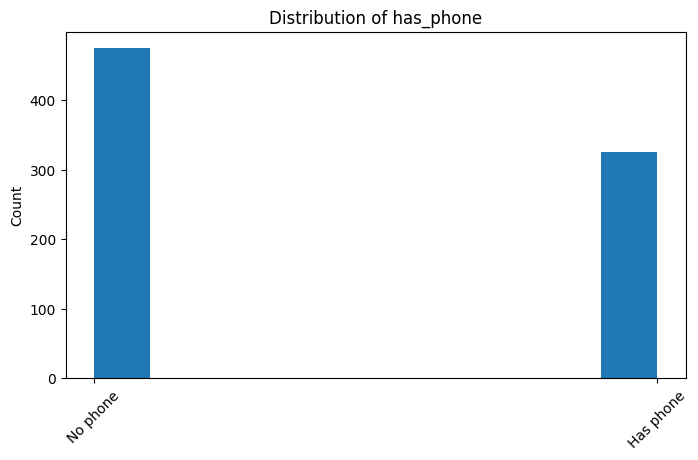

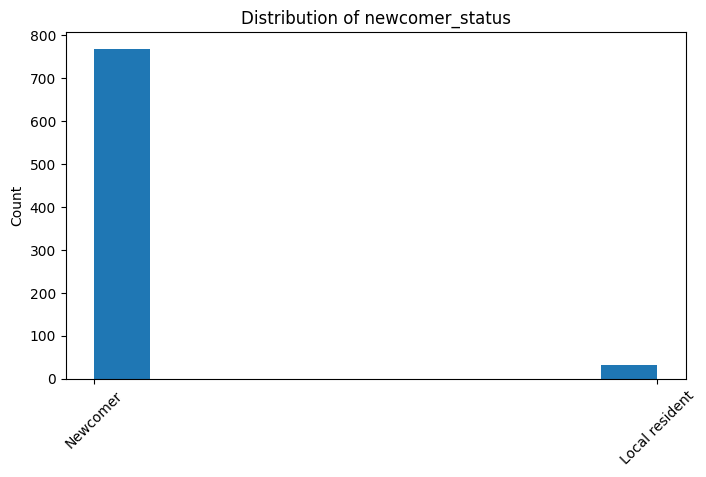

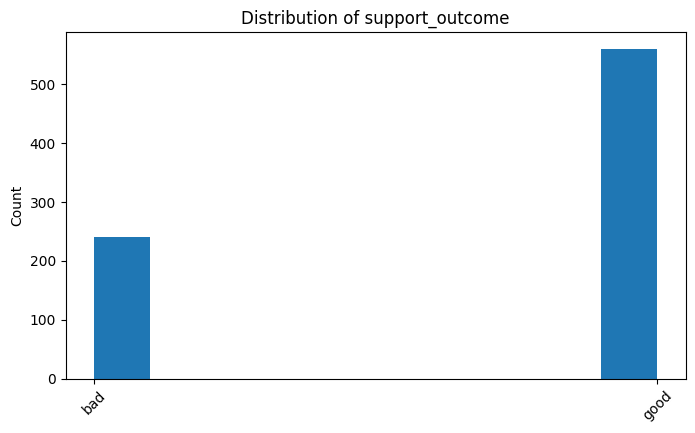

In [7]:
# Plots the distribution of each categorical value
for column in df.columns:
    if df.dtypes[column] == "object":
        fig, ax = plt.subplots()
        fig.set_size_inches(8, 4.5)
        ax.hist(df[column].fillna("N/A"))
        ax.set_title(f"Distribution of {column}")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", labelrotation=45)
        plt.show()
        plt.close()

A partir dos histogramas acima, é possível notar como há uma grande desbalanceamento na distribuição de alguns valores e, em particular, na distribuição do rótulo a ser predito, seja ele referente à coluna "*support_outcome*". Em função disso, para fins de separação de conjuntos de treino e de validação, será interessante realizar esse processo de tal forma a manter a proporção entre as classes.

A seguir, é verificada a existência de valores faltantes.

In [8]:
# Checks if there are any missing values
df.isna().any(axis=0)

id                               False
garden_points_status             False
commitment_months                False
participation_history            False
project_focus_code               False
requested_resources_value        False
personal_reserve_status          False
volunteer_tenure_bracket         False
time_commitment_rate             False
household_profile                False
co_sponsor_presence              False
years_in_neighborhood_bracket    False
asset_contribution_type          False
member_age                       False
other_support_plans               True
housing_situation                False
existing_commitments_count       False
role_skill_tier                  False
dependents_supported             False
has_phone                        False
newcomer_status                  False
support_outcome                  False
dtype: bool

É possível observar que apenas a coluna "*other_support_plans*" possui valores faltantes. Nas próximas etapas, as quais abordarão o pré-processamento desses dados, essas lacunas deverão ser tratadas de alguma forma.

A fim de aprofundar mais a compreensão desses vazios nos dados, a seguir, são isoladas as informações pertinentes a quais valores essa coluna em específico pode assumir, e também é contada a quantidade de entradas com valores faltantes.

In [9]:
# Unique values of the column "other_support_plans"
df["other_support_plans"].unique()

array([nan, 'Partner bank', 'Partner stores'], dtype=object)

In [10]:
# Quantity of missing values
df["other_support_plans"].isna().sum()

np.int64(649)

Dado que a base de dados como um todo possui 800 entradas, pode-se notar como a maior parte delas, mais de dois terços, não possui um valor para essa coluna em específico. Tal observação possuirá impacto na decisão de como tratar esses valores faltantes.

## **Pré-Processamento Inicial**

Uma vez com uma compreensão mais profunda dos dados com os quais se trabalha, o próximo passo consiste em um pré-processamento inicial dessas informações. A ideia é, em grande medida, limpar a base de dados como um todo e potencialmente processar algumas colunas a fim de as deixar mais tratáveis de maneira geral, independente do modelo escolhido. Para tal, aqui, três principais tarefas serão aplicadas: o tratamento dos dados faltantes identificados, a normalização das colunas numéricas e a conversão das colunas categóricas em numéricas.

In [11]:
# Reading the data again, just to make sure it is clean
# and not affected from the previous step
df = pd.read_csv("dados/df_train.csv")

O primeiro passo, como mencionado, é lidar com as entradas com dados faltantes. Retomando as observações feitas na seção de análise exploratória, apenas a coluna "*other_support_plans*" possui lacunas. Dado que a maioria das entradas (649 de 800) não possui um valor para tal coluna, além de que, pela sua distribuição, não parece que ela seja decisiva em termos da tarefa de classificação, foi optado pela sua simples remoção.

Uma alternativa teria sido fazer uma suposição semântica de que indivíduos sem um valor para ela apenas não possuiriam um plano de suporte. Entretanto, dado que a maioria não possui um valor, foi julgado que essa suposição seria demasiadamente forte.

In [12]:
# Drops column with missing values
df = df.drop(["other_support_plans"], axis=1)

Em seguida, foi feita uma normalização dos atributos numéricos da base de dados. Para tal, foi escolhida a normalização *z-score*, a qual mapeia os dados à quantidade correspondente de desvios-padrão da média. Esta abordagem tende a funcionar bem no geral, então foi julgada um bom primeiro passo.

In [13]:
# Filters the numeric columns
numeric_columns = []
for column in list(df.columns):
    if df.dtypes[column] == "float64":
        numeric_columns.append(column)

# Normalizes values (z-score)
df[numeric_columns] = (df[numeric_columns] - np.mean(df[numeric_columns], axis=0)) / (
    np.std(df[numeric_columns], axis=0)
)

Por fim, foi feita uma codificação das colunas categóricas em valores numéricos. A principal razão para isso se deve ao fato de que a biblioteca utilizada para o treinamento dos modelos, SciKit Learn, implementa-os de tal forma que eles aceitam apenas entradas numéricas, mesmo modelos como árvores de decisão, os quais deveriam ser robustos a atributos categóricos. Para isso, em um primeiro momento, foi escolhida uma codificação via *one-hot encoding*, a qual, novamente, também é geralmente razoável e tende a funcionar bem em uma grande quantidade de casos.

In [14]:
# Filters the categorical columns
categorical_columns = []
for column in list(df.columns):
    if df.dtypes[column] == "object":
        categorical_columns.append(column)
categorical_columns.remove(
    "support_outcome"
)  # The dependent variable will be dealt with separately

# Encodes the target column
df["support_outcome"] = df["support_outcome"].map({"bad": 0, "good": 1})

# Encodes the other categorical columns
for column in categorical_columns:
    one_hot = pd.get_dummies(df[column], dtype=int)
    df = df.drop(column, axis=1)
    df = df.join(one_hot)

Para finalizar, uma vez que todas as colunas sejam numéricas, uma possibilidade que surge é a plotagem desses valores em um gráfico. A fim de alcançar isso, utilizou-se a técnica de redução de dimensionalidade PCA e suas duas primeiras componentes principais. A ideia é tentar se ter uma visão mais aprofundada da distribuição espacial dos dados em um espaço bidimensional.

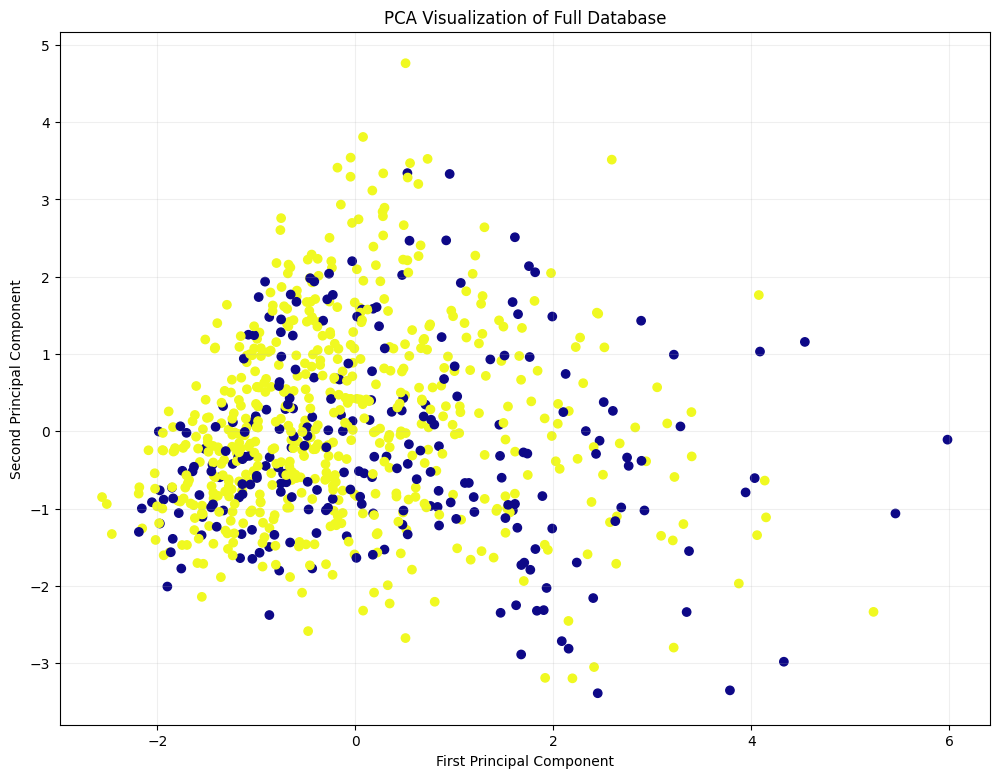

In [15]:
# Removes the id and the target columns for plotting
data = df.drop("id", axis=1)
data = data.drop("support_outcome", axis=1)

# PCA for visualization in 2D
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(
    x=pca_data[:, 0], y=pca_data[:, 1], c=df["support_outcome"], cmap="plasma", zorder=1
)
ax.set_title("PCA Visualization of Full Database")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

plt.grid(alpha=0.2)
plt.show()
plt.close()

Apenas a partir da visualização acima, percebe-se que o conjunto de dados não aparenta possuir uma regionalização natural das classes. Entretanto, essa observação deve levar em conta as próprias limitações da técnica de PCA e o fato de que os dados, uma vez processados, possuem uma quantidade grande de dimensões (60), de modo que muita informação possa estar sendo perdida nessa redução.

In [16]:
# Full function for later use
def initial_pre_processing(df):
    df = df.drop(["other_support_plans"], axis=1)
    numeric_columns = []
    for column in list(df.columns):
        if df.dtypes[column] == "float64":
            numeric_columns.append(column)
    df[numeric_columns] = (
        df[numeric_columns] - np.mean(df[numeric_columns], axis=0)
    ) / (np.std(df[numeric_columns], axis=0))
    categorical_columns = []
    for column in list(df.columns):
        if df.dtypes[column] == "object":
            categorical_columns.append(column)
    categorical_columns.remove("support_outcome")
    df["support_outcome"] = df["support_outcome"].map({"bad": 0, "good": 1})
    for column in categorical_columns:
        one_hot = pd.get_dummies(df[column], dtype=int)
        df = df.drop(column, axis=1)
        df = df.join(one_hot)
    return df

## **Seleção de um Modelo**

Uma vez com uma primeira versão dos dados tratados em mãos, o próximo passo consiste na seleção de um ou mais modelos a serem utilizados para a tarefa de predição. A abordagem escolhida para tal seleção foi treinar uma quantidade variada de modelos, utilizando os hiperparâmetros e demais configurações nos valores padrão da biblioteca, e escolher aqueles que apresentarem um melhor comportamento. Também pretende-se selecionar mais de um que sejam baseados em diferentes premissas, a fim de se explorar com maior robustez todo o espaço de possibilidades.

A seguir, o conjunto de dados é separado em porções de treinamento e de validação. Como mencionado, o conjunto de testes já está separado. Além disso, a separação foi feita de tal forma a se manter a proporção entre as classes dos dados. O objetivo é apenas obter um resultado preliminar que colabore com a seleção de um ou mais modelos.

In [17]:
def train_val_sep(df):
    # Shuffles the database
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

    # Separates labels
    y = df[["id", "support_outcome"]]
    X = df.drop(["support_outcome"], axis=1)

    # Stratified train/val separation
    zero = df[df["support_outcome"] == 0].copy()
    one = df[df["support_outcome"] == 1].copy()

    zero_split = int(0.7 * zero.shape[0])
    one_split = int(0.7 * one.shape[0])

    train = pd.concat([zero.iloc[:zero_split], one.iloc[:one_split]]).reset_index(
        drop=True
    )
    X_train = train.drop(["support_outcome", "id"], axis=1)
    y_train = train["support_outcome"]

    val = pd.concat([zero.iloc[zero_split:], one.iloc[one_split:]]).reset_index(
        drop=True
    )
    X_val = val.drop(["support_outcome", "id"], axis=1)
    y_val = val["support_outcome"]

    return X_train, y_train, X_val, y_val


X_train, y_train, X_val, y_val = train_val_sep(df)

Dentre os modelos escolhidos para avaliação, estão os seguintes: *Gradient Boosting*, *Adaboost*, *Random Forest*, *Linear Support Vector Machine* e *Logistic Regression*. Foi julgado que esse acervo inicial é variado o suficiente e contém modelos robustos e capazes de lidar com esses dados. Utilizando os hiperparâmetros padrão da biblioteca, para cada um, é feito um treinamento no conjunto de treino e, em seguida, o cálculo de várias métricas no conjunto de validação.

In [18]:
# Auxiliary function to calculate various metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

In [19]:
# Training and validating various models
model = GradientBoostingClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

print("### Gradient Boosting ###")
print(f"Acc: {accuracy}")
print(f"Pre: {precision}")
print(f"Rec: {recall}")
print(f"F1: {f1}")
print()

# Training and validating various models
model = AdaBoostClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

print("### Ada Boost ###")
print(f"Acc: {accuracy}")
print(f"Pre: {precision}")
print(f"Rec: {recall}")
print(f"F1: {f1}")
print()

# Training and validating the model
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

print("### Random Forest ###")
print(f"Acc: {accuracy}")
print(f"Pre: {precision}")
print(f"Rec: {recall}")
print(f"F1: {f1}")
print()

# Training and validating the model
model = LinearSVC(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

print("### SVM ###")
print(f"Acc: {accuracy}")
print(f"Pre: {precision}")
print(f"Rec: {recall}")
print(f"F1: {f1}")
print()

# Training and validating the model
model = LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

print("### Logistic Regression ###")
print(f"Acc: {accuracy}")
print(f"Pre: {precision}")
print(f"Rec: {recall}")
print(f"F1: {f1}")
print()

### Gradient Boosting ###
Acc: 0.7708333333333334
Pre: 0.7927461139896373
Rec: 0.9107142857142857
F1: 0.8476454293628809

### Ada Boost ###
Acc: 0.75
Pre: 0.78125
Rec: 0.8928571428571429
F1: 0.8333333333333334

### Random Forest ###
Acc: 0.7458333333333333
Pre: 0.7688442211055276
Rec: 0.9107142857142857
F1: 0.8337874659400545

### SVM ###
Acc: 0.775
Pre: 0.8
Rec: 0.9047619047619048
F1: 0.8491620111731844

### Logistic Regression ###
Acc: 0.7625
Pre: 0.7875647668393783
Rec: 0.9047619047619048
F1: 0.8421052631578947



Os resultados para todos os modelos foram bem similares, mas parece que o *Gradient Boosting* e o *SVM Linear* apresentaram métricas marginalmente melhores. Assim, ambos foram escolhidos como os modelos a serem utilizados no restante deste trabalho.

Um pequeno *tuning* de hiperparâmetros foi feito de maneira manual com o intuito de se compreender melhor o comportamento desses modelos para com os dados em mãos. Os melhores valores encontrados são registrados nas células a seguir.

In [20]:
def train_grad(X_train, y_train, X_val, y_val):
    # Manual hyperparameter tuning of Gradient Boosting
    grad = GradientBoostingClassifier(
        learning_rate=0.1,
        n_estimators=100,
        subsample=0.8,
        max_depth=5,
        max_features="sqrt",
        random_state=RANDOM_STATE,
    )
    grad.fit(X_train, y_train)
    y_pred = grad.predict(X_val)
    accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

    print("### Manually Tuned Gradient Boosting ###")
    print(f"Acc: {accuracy}")
    print(f"Pre: {precision}")
    print(f"Rec: {recall}")
    print(f"F1: {f1}")
    print()

    return grad


grad = train_grad(X_train, y_train, X_val, y_val)

### Manually Tuned Gradient Boosting ###
Acc: 0.7791666666666667
Pre: 0.8108108108108109
Rec: 0.8928571428571429
F1: 0.8498583569405099



In [21]:
def train_svm(X_train, y_train, X_val, y_val):
    # Manual hyperparameter tuning of Gradient Boosting
    svm = LinearSVC(
        penalty="l2",
        loss="squared_hinge",
        C=1.0,
        tol=1e-6,
        max_iter=10000,
        random_state=RANDOM_STATE,
    )
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

    print("### Manually Tuned SVM ###")
    print(f"Acc: {accuracy}")
    print(f"Pre: {precision}")
    print(f"Rec: {recall}")
    print(f"F1: {f1}")
    print()

    return svm


svm = train_svm(X_train, y_train, X_val, y_val)

### Manually Tuned SVM ###
Acc: 0.775
Pre: 0.8
Rec: 0.9047619047619048
F1: 0.8491620111731844



Por fim, as matrizes de confusão dos dois modelos escolhidos são apresentadas a seguir.

In [16]:
# Creates and displays a confusion matrix
def confusion_matrix(y_true, y_pred):
    true_0 = y_true == 0
    true_1 = y_true == 1

    true_negative = sum(y_pred[true_0] == 0)
    false_negative = sum(y_pred[true_1] == 0)

    true_positive = sum(y_pred[true_1] == 1)
    false_positive = sum(y_pred[true_0] == 1)

    confusion_matrix = {
        "Predicted 0": [true_negative, false_negative, true_negative + false_negative],
        "Predicted 1": [false_positive, true_positive, false_positive + true_positive],
        "Total": [
            true_negative + false_positive,
            false_negative + true_positive,
            true_negative + false_negative + false_positive + true_positive,
        ],
    }
    confusion_matrix = pd.DataFrame.from_dict(
        confusion_matrix, orient="index", columns=["True 0", "True 1", "Total"]
    )

    display(confusion_matrix)

In [23]:
# Confusion matrix for Gradient Boosting
confusion_matrix(y_val, grad.predict(X_val))

,True 0,True 1,Total
Predicted 0,37,18,55
Predicted 1,35,150,185
Total,72,168,240


In [24]:
# Confusion matrix for SVM
confusion_matrix(y_val, svm.predict(X_val))

,True 0,True 1,Total
Predicted 0,34,16,50
Predicted 1,38,152,190
Total,72,168,240


A partir das matrizes de confusão, é possível observar que ambos os modelos conseguem predizer muito melhor aquelas instâncias pertencentes à classe 1. Isso não é um resultado muito interessante, dado que, considerando o contexto deste trabalho, pensa-se que é mais relevante conseguir acertar com precisão aquelas pessoas que têm uma maior probabilidade de não continuarem no projeto do jardim (classe 0). Entretanto, é um começo razoável.

## **Experimentos**

### Seleção de Atributos Categóricos

Uma vez feito o pré-processamento inicial, observa-se que a base de dados como um todo ficou com uma quantidade de dimensões muito grande, o que nem sempre pode ser favorável aos métodos de aprendizado. Por exemplo, uma árvore de decisão com esse número de dimensões teria que ser muito profunda, aumentando sua complexidade. De maneira geral, tem-se o problema do "mal da dimensionalidade", em que os dados passam a se comportar numericamente de um modo ruim, como, por exemplo, tendendo a uma distância constante uns dos outros, o que prejudica tarefas de classificação.

Nesse contexto, uma primeira possibilidade elencada foi a seleção de apenas um subconjunto dos atributos categóricos. Por terem sido codificados via *one-hot encoding*, eles contribuem muito com a dimensão dos dados. Para essa seleção, a abordagem adotada foi computar a entropia de cada um desses atributos e, em seguida, escolher aquele com a mais baixa, o qual, em teoria, deveria colaborar mais com a separação entre as classes. A entropia é calculada dentro dos valores que esses atributos podem assumir, com relação à distribuição das classes para eles. A ideia é que um atributo com valores tais que uma das classes domina em cada um possuirá uma entropia mais baixa e será mais relevante para fins de classificação.

In [25]:
# Reading the data again, just to make sure it is clean
data = pd.read_csv("dados/df_train.csv")

In [26]:
# Calculates and shows the entropy of each column
for column in categorical_columns:
    print(column)
    entropy = 0
    for value in data[column].unique():
        mask = data[data[column] == value]
        zeroes = mask[mask["support_outcome"] == "bad"].shape[0]
        ones = mask[mask["support_outcome"] == "good"].shape[0]
        print(f"value: {str(value)[:5]}...\t\tzeroes={zeroes}\tones={ones}")

        prob_zero = zeroes / mask.shape[0] if mask.shape[0] > 0 else 0
        prob_one = ones / mask.shape[0] if mask.shape[0] > 0 else 0

        entropy_zero = prob_zero * np.log2(prob_zero) if prob_zero > 0 else 0
        entropy_one = prob_one * np.log2(prob_one) if prob_one > 0 else 0

        entropy += -entropy_zero - entropy_one
    entropy /= len(data[column].unique())
    print(f"entropy: {entropy}\n")

garden_points_status
value: Point...		zeroes=105	ones=114
value: No po...		zeroes=38	ones=278
value: Point...		zeroes=84	ones=130
value: Point...		zeroes=13	ones=38
entropy: 0.8285584271763069

participation_history
value: Previ...		zeroes=134	ones=282
value: Issue...		zeroes=42	ones=198
value: All r...		zeroes=22	ones=19
value: No pr...		zeroes=19	ones=12
value: Delay...		zeroes=23	ones=49
entropy: 0.887698812895608

project_focus_code
value: Trans...		zeroes=16	ones=68
value: Commu...		zeroes=46	ones=169
value: Works...		zeroes=49	ones=100
value: Share...		zeroes=3	ones=7
value: Trans...		zeroes=70	ones=124
value: Train...		zeroes=20	ones=20
value: Retra...		zeroes=1	ones=4
value: Plot ...		zeroes=7	ones=11
value: Other...		zeroes=2	ones=4
value: Micro...		zeroes=26	ones=53
entropy: 0.8708172781156532

personal_reserve_status
value: No re...		zeroes=24	ones=120
value: Reser...		zeroes=173	ones=302
value: Reser...		zeroes=30	ones=60
value: Reser...		zeroes=5	ones=36
value: Reser...		z

In [27]:
# Isolates the columns with lower entropy
interesting_columns = ["newcomer_status", "personal_reserve_status"]

# Pre-processes the data up until the numerical columns
data = data.drop(["other_support_plans"], axis=1)
data[numeric_columns] = (
    data[numeric_columns] - np.mean(data[numeric_columns], axis=0)
) / (np.std(data[numeric_columns], axis=0))
data["support_outcome"] = data["support_outcome"].map({"bad": 0, "good": 1})

# Removes irrelevant categorical columns
data = data.drop(
    [x for x in categorical_columns if x not in interesting_columns], axis=1
)

# Encodes the relevant categorical columns
for column in interesting_columns:
    one_hot = pd.get_dummies(data[column], dtype=int)
    data = data.drop(column, axis=1)
    data = data.join(one_hot)

In [28]:
# Verifies the performance of the applied method
# over both previous models
X_train, y_train, X_val, y_val = train_val_sep(data)
grad = train_grad(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, grad.predict(X_val))
svm = train_svm(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, svm.predict(X_val))

### Manually Tuned Gradient Boosting ###
Acc: 0.675
Pre: 0.7368421052631579
Rec: 0.8333333333333334
F1: 0.7821229050279329



,True 0,True 1,Total
Predicted 0,22,28,50
Predicted 1,50,140,190
Total,72,168,240


### Manually Tuned SVM ###
Acc: 0.7291666666666666
Pre: 0.7440758293838863
Rec: 0.9345238095238095
F1: 0.8284960422163589



,True 0,True 1,Total
Predicted 0,18,11,29
Predicted 1,54,157,211
Total,72,168,240


É possível observar que a performance de ambos os modelos caiu razoavelmente. Em particular, observando-se as matrizes de confusão, a capacidade de distinção da classe 0 foi a mais afetada, o que vai contra os objetivos pretendidos para este trabalho. Um dos problemas identificados para a abordagem adotada é justamente que uma medida de entropia global pode não capturar a maneira como o atributo irá contribuir de maneira local no modelo. Por exemplo, em uma árvore de decisão, uma primeira divisão em um outro atributo já muda a maneira como as classes serão divididas em seguida.

### Seleção de Atributos Numéricos

De maneira análoga àquilo feito para os atributos categóricos, também é possível realizar uma filtragem nos atributos numéricos a fim de reduzir a dimensionalidade dos dados. Para isso, a abordagem adotada foi a utilização de um modelo de regressão logística regularizado por meio da norma L1 (*Lasso*). Essa forma de regularização do modelo é notoriamente conhecida por levar o valor dos coeficientes associados a atributos redundantes (como linearmente correlacionados) a zero, permitindo a sua filtragem.

In [29]:
# Reading the data again, just to make sure it is clean
data = pd.read_csv("dados/df_train.csv")

In [30]:
# Extracts and pre-processes only numeric columns
data = data.drop(["other_support_plans"], axis=1)
data[numeric_columns] = (
    data[numeric_columns] - np.mean(data[numeric_columns], axis=0)
) / (np.std(data[numeric_columns], axis=0))
data["support_outcome"] = data["support_outcome"].map({"bad": 0, "good": 1})
data = data.drop(categorical_columns, axis=1)

In [31]:
# Trains a regression model to verify the coefficients
X_train, y_train, X_val, y_val = train_val_sep(data)

logit = LogisticRegression(
    penalty="l1",
    C=0.1,
    tol=1e-6,
    max_iter=10000,
    random_state=RANDOM_STATE,
    solver="liblinear",
)
logit.fit(X_train, y_train)
logit.coef_

array([[-0.27781359, -0.13128057, -0.20122758,  0.        ,  0.0539148 ,
         0.03931307,  0.        ]])

In [32]:
numeric_columns[:3]

['commitment_months', 'requested_resources_value', 'time_commitment_rate']

In [33]:
# Reading the data again, just to make sure it is clean
data = pd.read_csv("dados/df_train.csv")

In [34]:
# Pre-processes it, but including only the relevant numerical columns
data = data.drop(["other_support_plans"], axis=1)

data = data.drop(numeric_columns[3:], axis=1)
filtered_numeric_columns = numeric_columns[:3]
data[filtered_numeric_columns] = (
    data[filtered_numeric_columns] - np.mean(data[filtered_numeric_columns], axis=0)
) / (np.std(data[filtered_numeric_columns], axis=0))

data["support_outcome"] = data["support_outcome"].map({"bad": 0, "good": 1})

for column in categorical_columns:
    one_hot = pd.get_dummies(data[column], dtype=int)
    data = data.drop(column, axis=1)
    data = data.join(one_hot)

In [35]:
# Verifies the performance of the applied method
# over both previous models
X_train, y_train, X_val, y_val = train_val_sep(data)
grad = train_grad(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, grad.predict(X_val))
svm = train_svm(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, svm.predict(X_val))

### Manually Tuned Gradient Boosting ###
Acc: 0.725
Pre: 0.7684210526315789
Rec: 0.8690476190476191
F1: 0.8156424581005587



,True 0,True 1,Total
Predicted 0,28,22,50
Predicted 1,44,146,190
Total,72,168,240


### Manually Tuned SVM ###
Acc: 0.775
Pre: 0.796875
Rec: 0.9107142857142857
F1: 0.85



,True 0,True 1,Total
Predicted 0,33,15,48
Predicted 1,39,153,192
Total,72,168,240


O processo realizado permitiu identificar que, dentre os 7 atributos numéricos, apenas 3 parecem ser realmente relevantes, sendo eles "*commitment_months*", "*requested_resources_value*" e "*time_commitment_rate*". Os demais, possivelmente, são linearmente correlacionados com algum destes três, de forma que sejam apenas fatores de confusão e tenham sido eliminados.

Os modelos foram treinados novamente em seguida e, a partir dos resultados acima, é possível perceber que, enquanto o *Gradient Boosting* sofreu uma degradação de performance, o *SVM* foi beneficiado pelo filtro aplicado. Esses resultados são um tanto esperados, dado que o *SVM*, sendo um modelo linear, é particularmente afetado por multicolinearidade nos atributos, a qual se manifesta como um fator adicional de confusão que implica em instabilidades numéricas nos coeficientes.

### Criação de um Embedding

Inicialmente, a fim de converter os atributos categóricos em uma representação numérica, tratável pelos modelos disponibilizados na biblioteca SciKit Learn, foi utilizada uma abordagem baseada em *one-hot encoding*, a qual é simples e, de maneira geral, tende a funcionar razoavelmente. Entretanto, uma alternativa é a criação de *embeddings*, representações numéricas vetoriais de um conjunto de dados categóricos que capturam em alguma medida suas relações semânticas por meio de suas distâncias no espaço em que existem.

A criação de *embeddings* para um conjunto de dados categóricos pode ser feita por meio de uma rede neural organizada da seguinte forma. Primeiro, define-se um módulo responsável pela criação dos *embeddings* propriamente ditos. Ele possui apenas uma camada, conectando a representação em *one-hot encoding* dos atributos categóricos a uma quantidade D de neurônios, sendo D a dimensão desejada para o *embedding*. A ideia é que uma entrada baseada em *one-hot encoding* em uma rede de apenas uma camada tem o efeito de apenas selecionar linhas de pesos associadas às conexões para as quais os valores são 1. Dessa forma, nos valores dos pesos dessa camada, a rede acaba aprendendo representações numéricas para as combinações de atributos fornecidos na entrada. A saída desse módulo - o *embedding* propriamente dito - é então fornecida a uma outra rede, um *multi-layer perceptron* comum, que, além disso, também recebe os atributos numéricos, e tenta prever o rótulo da respectiva entrada. Esse processo de otimização faz com que as representações numéricas aprendidas sejam tais que capturem melhor aspectos relevantes da entrada para a tomada de decisão por parte do modelo.

Todo esse processo foi implementado com o auxílio da biblioteca PyTorch e está apresentado a seguir.

In [36]:
# Reading the data again, just to make sure it is clean
data = pd.read_csv("dados/df_train.csv")

# Pre-processing it
data = initial_pre_processing(data)

# Transforming the data to tensors
X = torch.FloatTensor(data.drop(["support_outcome", "id"], axis=1).to_numpy())
y = torch.FloatTensor(data["support_outcome"].to_numpy())
y = y.reshape(y.shape[0], 1)


# Defining the embedding model
class Embedding(nn.Module):
    def __init__(self, **kwargs):
        super(Embedding, self).__init__(**kwargs)

        self.embedding = nn.Sequential(
            nn.Linear(51, 20),
            nn.ReLU(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(27, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, X):
        numerical_attributes = X[:, 0:7]
        categorical_attributes = X[:, 7:]

        emb = self.embedding(categorical_attributes)

        mlp_input = torch.cat([numerical_attributes, emb], dim=1)
        out = self.mlp(mlp_input)

        return out

    def get_emb(self, X):
        X = torch.FloatTensor(X.to_numpy())

        numerical_attributes = X[:, 0:7]
        categorical_attributes = X[:, 7:]

        emb = self.embedding(categorical_attributes)
        return torch.cat([numerical_attributes, emb], dim=1).detach().numpy()

In [ ]:
# Declares the model
model = Embedding()

# Trains the model
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

loss_list = []
for epoch in range(50000):
    preds = model.forward(X)
    loss = criterion(preds, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}: loss = {loss.item():.5f}")

A arquitetura, os hiperparâmetros de regularização (*dropout* e *weight decay*) e os parâmetros de treinamento da rede foram todos definidos de maneira empírica, por meio de tentativa e erro. No final, um *embedding* com 20 dimensões funcionou bem.

Uma vez com o modelo de criação de *embeddings* em mãos, ele é utilizado para o pré-processamento da base de dados, a qual é fornecida aos dois modelos sendo avaliados para fins de validação.

In [38]:
# Verifies the performance of the applied method
# over both previous models
X_train, y_train, X_val, y_val = train_val_sep(data)
X_train = model.get_emb(X_train)
X_val = model.get_emb(X_val)
grad = train_grad(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, grad.predict(X_val))
svm = train_svm(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, svm.predict(X_val))

### Manually Tuned Gradient Boosting ###
Acc: 0.775
Pre: 0.796875
Rec: 0.9107142857142857
F1: 0.85



,True 0,True 1,Total
Predicted 0,33,15,48
Predicted 1,39,153,192
Total,72,168,240


### Manually Tuned SVM ###
Acc: 0.9041666666666667
Pre: 0.9190751445086706
Rec: 0.9464285714285714
F1: 0.9325513196480938



,True 0,True 1,Total
Predicted 0,58,9,67
Predicted 1,14,159,173
Total,72,168,240


In [ ]:
"""# Saves the model's weights
torch.save(model.state_dict(), "./tmp")"""

In [ ]:
"""# Loads the model's weights
model = Embedding()
model.load_state_dict(torch.load("./this_is_VERY_good", weights_only=True))"""

<All keys matched successfully>

É possível observar como a utilização do modelo de *embedding* melhorou significativamente a performance do SVM Linear. Em contrapartida, o modelo de *Gradient Boosting* não foi tão beneficiado.

Uma possível explicação para o sucesso do SVM Linear possivelmente está relacionada com a mudança de espaço aplicada pelo *embedding*. Em particular, o espaço de *embeddings* é caracterizado por capturar elementos essenciais dos dados em cada uma de suas dimensões, maximizando a capacidade de separação do modelo. Possivelmente, neste novo espaço criado pela rede neural, por mais que ele possua menos dimensões (20 para o *embedding*, 27 também considerando os dados numéricos) do que o espaço original (51) aconteceu de os dados serem razoavelmente linearmente separáveis, de modo que o SVM Linear tenha se adequado bem.

Entretanto, um problema que surge com essa interpretação seria que, mesmo em uma situação como esta, o *Gradient Boosting* ainda deveria ser capaz de se comportar bem. Uma hipótese que justificaria um desempenho aquém deste modelo seria a fronteira de separação dos dados não estar alinhada com os eixos do espaço. Isto não é um problema para o SVM Linear, cujo hiperplano de separação pode estar em qualquer posição, mas para um modelo baseado em árvores, as quais só conseguem realizar divisões alinhadas aos eixos, isto pode se tornar um fator limitante.

### Combinando Abordagens

Os últimos dois experimentos para processamento de atributos - a filtragem de colunas numéricas redundantes e a criação de *embeddings* para as colunas categóricas - originaram resultados muito positivos para o modelo de SVM Linear. Com isto, nesta seção, busca-se verificar se a junção de ambas as abordagens irá favorecer ainda mais este modelo. Isto é, primeiro, as colunas numéricas redundantes serão removidas da base de dados e, em seguida, o modelo de *embeddings* será treinado e aplicado sobre as colunas categóricas.

In [39]:
# Auxiliary function to filter the database of irrelevant numerical columns
def filters_numerical_columns(data):
    # Pre-processes it, but including only the relevant numerical columns
    data = data.drop(["other_support_plans"], axis=1)
    data = data.drop(numeric_columns[3:], axis=1)
    filtered_numeric_columns = numeric_columns[:3]
    data[filtered_numeric_columns] = (
        data[filtered_numeric_columns] - np.mean(data[filtered_numeric_columns], axis=0)
    ) / (np.std(data[filtered_numeric_columns], axis=0))
    data["support_outcome"] = data["support_outcome"].map({"bad": 0, "good": 1})
    for column in categorical_columns:
        one_hot = pd.get_dummies(data[column], dtype=int)
        data = data.drop(column, axis=1)
        data = data.join(one_hot)
    return data

In [40]:
# Reading the data again, just to make sure it is clean
data = pd.read_csv("dados/df_train.csv")
data = filters_numerical_columns(data)

# Transforms it to a tensor
X = torch.FloatTensor(data.drop(["support_outcome", "id"], axis=1).to_numpy())
y = torch.FloatTensor(data["support_outcome"].to_numpy())
y = y.reshape(y.shape[0], 1)


# Defining the embedding model
class Embedding(nn.Module):
    def __init__(self, **kwargs):
        super(Embedding, self).__init__(**kwargs)

        self.embedding = nn.Sequential(
            nn.Linear(51, 20),
            nn.ReLU(),
        )

        self.mlp = nn.Sequential(
            nn.Linear(23, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, X):
        numerical_attributes = X[:, 0:3]
        categorical_attributes = X[:, 3:]

        emb = self.embedding(categorical_attributes)

        mlp_input = torch.cat([numerical_attributes, emb], dim=1)
        out = self.mlp(mlp_input)

        return out

    def get_emb(self, X):
        X = torch.FloatTensor(X.to_numpy())

        numerical_attributes = X[:, 0:3]
        categorical_attributes = X[:, 3:]

        emb = self.embedding(categorical_attributes)
        return torch.cat([numerical_attributes, emb], dim=1).detach().numpy()

In [ ]:
# Declares the model
model = Embedding()

# Trains the model
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

loss_list = []
for epoch in range(50000):
    preds = model.forward(X)
    loss = criterion(preds, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}: loss = {loss.item():.5f}")

In [42]:
# Verifies the performance of the applied method
# over both previous models
X_train, y_train, X_val, y_val = train_val_sep(data)
X_train = model.get_emb(X_train)
X_val = model.get_emb(X_val)
grad = train_grad(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, grad.predict(X_val))
svm = train_svm(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, svm.predict(X_val))

### Manually Tuned Gradient Boosting ###
Acc: 0.8291666666666667
Pre: 0.8359788359788359
Rec: 0.9404761904761905
F1: 0.8851540616246498



,True 0,True 1,Total
Predicted 0,41,10,51
Predicted 1,31,158,189
Total,72,168,240


### Manually Tuned SVM ###
Acc: 0.95
Pre: 0.9588235294117647
Rec: 0.9702380952380952
F1: 0.9644970414201184



,True 0,True 1,Total
Predicted 0,65,5,70
Predicted 1,7,163,170
Total,72,168,240


In [ ]:
"""# Saves the model's weights
torch.save(model.state_dict(), "./tmp")"""

In [ ]:
"""# Loads the model's weights
model = Embedding()
model.load_state_dict(torch.load("./this_is_VERY_VERY_VERY_good", weights_only=True))"""

<All keys matched successfully>

Os resultados acima demonstram uma melhora extremamente positiva para o modelo SVM Linear, o qual atingiu resultados muito satisfatórios para o conjunto de validação. A matriz de confusão também confirma que a performance, antes boa para a classe positiva mas ruim para a classe negativa, equalizou-se e alcançou um patamar razoável para ambas.

O treinamento do modelo baseado em *Gradient Boosting* também foi feito, mesmo já tendo se confirmado que as abordagens de pré-processamento dos dados aplicadas não foram muito efetivas para ele. De fato, os resultados não melhoraram muito.

## **Investigando o Problema com o *Gradient Boosting***

Como mencionado previamente, uma possível explicação para uma performance aquém do *Gradient Boosting* talvez esteja associada à fronteira de separação linear entre os dados, capturada pelo SVM, não estar alinhada aos eixos do espaço, o que prejudica modelos baseados em árvores. A fim de se investigar isto, foi utilizada a técnica do PCA, a qual origina uma nova base para o espaço dos dados na qual os eixos estão alinhados às dimensões de sua maior variância, o que possivelmente colaboraria com o problema mencionado.

In [43]:
# Reading the data again, just to make sure it is clean
data = pd.read_csv("dados/df_train.csv")
data = filters_numerical_columns(data)

# Separates the labels and creates the embedding
X = model.get_emb(data.drop(["support_outcome", "id"], axis=1))
y = data["support_outcome"]

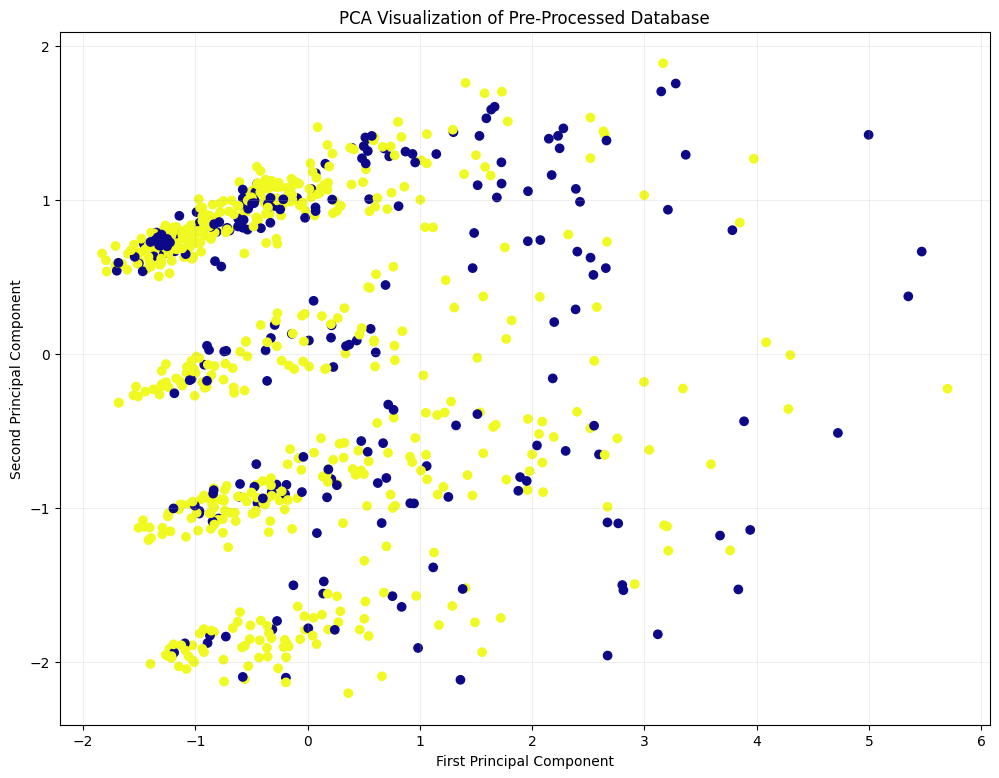

In [44]:
# PCA for visualization in 2D
pca = PCA()
pca_X = pca.fit_transform(X)

fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=pca_X[:, 0], y=pca_X[:, 1], c=y, cmap="plasma", zorder=1)
ax.set_title("PCA Visualization of Pre-Processed Database")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

plt.grid(alpha=0.2)
plt.show()
plt.close()

In [45]:
# Verifies the performance of the applied method
# over both previous models
X_train, y_train, X_val, y_val = train_val_sep(data)
X_train = model.get_emb(X_train)
X_val = model.get_emb(X_val)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
grad = train_grad(X_train, y_train, X_val, y_val)
confusion_matrix(y_val, grad.predict(X_val))

### Manually Tuned Gradient Boosting ###
Acc: 0.8833333333333333
Pre: 0.8723404255319149
Rec: 0.9761904761904762
F1: 0.9213483146067416



,True 0,True 1,Total
Predicted 0,48,4,52
Predicted 1,24,164,188
Total,72,168,240


A partir dos resultados acima, é possível observar que, de fato, a projeção dos dados na base encontrada pelo PCA colaborou ligeiramente com a performance do *Gradient Boosting*. Entretanto, esse aumento, mesmo que positivo, foi bem ligeiro, de modo que não seja possível garantir a validade da hipótese levantada sobre seu desempenho aquém em comparação com o SVM Linear.

## ***Fine-tuning* de Hiperparâmetros**

Nesta seção, será feita um *fine-tuning* sobre os modelos trabalhados até o momento sobre a forma de tratamento dos dados que apresentou os melhores resultados para cada um. Para isso, será utilizada a biblioteca Optuna, a qual automatiza esse processo. A partir de um conjunto inicial de valores a serem testados, ela aplica um processo de busca no espaço de hiperparâmetros baseado na abordagem de otimização Bayesiana. A função a ser otimizada, neste caso, foi definida como a score F1 do modelo, a qual é calculada por meio da técnica de K-fold com separação em treino e em validação, utilizando 4 folds. A métrica F1 foi julgada razoável, dado que captura não apenas a acurácia bruta, mas também a qualidade intraclasse das predições.

### Gradient Boosting

In [47]:
## Hyperparameter fine-tuning
# Parameters
n_folds = 4
n_trials = 200

# Reading the data again, just to make sure it is clean
# and not affected from the previous step
df = pd.read_csv("dados/df_train.csv")

# Filters irrelevant numerical columns
df = filters_numerical_columns(df)

# Gets the embedding
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
y = df["support_outcome"].to_numpy()
X = model.get_emb(df.drop(["support_outcome", "id"], axis=1))
fold_size = int(X.shape[0] / n_folds)

# PCA
pca = PCA()
X = pca.fit_transform(X)


# Optimization function
def objective(trial):
    # Samples hiperparameters
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 1, 300)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Calculates the F1 for each fold
    val_f1 = []
    for i in range(n_folds):
        # Generates the folds
        X_train_fold = np.concat([X[: (i * fold_size)], X[((i + 1) * fold_size) :]])
        y_train_fold = np.concat([y[: (i * fold_size)], y[((i + 1) * fold_size) :]])
        X_val_fold = X[(i * fold_size) : ((i + 1) * fold_size)]
        y_val_fold = y[(i * fold_size) : ((i + 1) * fold_size)]

        # Fits the model
        grad = GradientBoostingClassifier(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            subsample=subsample,
            max_depth=max_depth,
            max_features=max_features,
            random_state=RANDOM_STATE,
        )
        grad.fit(X_train_fold, y_train_fold)

        # Calculates fold validation f1
        y_pred = grad.predict(X_val_fold)
        val_f1.append(f1_score(y_val_fold, y_pred))

    # Reports validation accuracy
    avg_val_f1 = np.mean(val_f1)
    return avg_val_f1


# Optimizes the hyperparameters
study = optuna.create_study(
    study_name="Bayesian Optimizer", sampler=TPESampler(), direction="maximize"
)
study.optimize(objective, n_trials=n_trials)

# Best values
f1 = study.best_trial.value
learning_rate = study.best_trial.params["learning_rate"]
n_estimators = study.best_trial.params["n_estimators"]
subsample = study.best_trial.params["subsample"]
max_depth = study.best_trial.params["max_depth"]
max_features = study.best_trial.params["max_features"]

# Logging
print()
print("==== BEST HYPERPARAMETER VALUES ====")
print("- f1:", f1)
print("- learning_rate:", learning_rate)
print("- n_estimators:", n_estimators)
print("- subsample:", subsample)
print("- max_depth:", max_depth)
print("- max_features:", max_features)

[I 2025-12-08 10:29:46,092] A new study created in memory with name: Bayesian Optimizer
[I 2025-12-08 10:29:46,334] Trial 0 finished with value: 0.8291182707554088 and parameters: {'learning_rate': 0.028234551505725663, 'n_estimators': 38, 'subsample': 0.6011710212395824, 'max_depth': 1, 'max_features': None}. Best is trial 0 with value: 0.8291182707554088.
[I 2025-12-08 10:29:46,533] Trial 1 finished with value: 0.8945853455157994 and parameters: {'learning_rate': 0.08816457378902895, 'n_estimators': 103, 'subsample': 0.509378485293817, 'max_depth': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8945853455157994.
[I 2025-12-08 10:29:47,553] Trial 2 finished with value: 0.8777764750456989 and parameters: {'learning_rate': 0.014813989270776082, 'n_estimators': 101, 'subsample': 0.6088091191988712, 'max_depth': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.8945853455157994.
[I 2025-12-08 10:29:48,204] Trial 3 finished with value: 0.8360602241973046 and parameters: 


==== BEST HYPERPARAMETER VALUES ====
- f1: 0.9504992825871224
- learning_rate: 0.09647283662420014
- n_estimators: 269
- subsample: 0.8688960561702681
- max_depth: 3
- max_features: sqrt


In [53]:
# Reading the data again, just to make sure it is clean
# and not affected from the previous step
df = pd.read_csv("dados/df_train.csv")

# Filters irrelevant numerical columns
df = filters_numerical_columns(df)

# Separates the labels and creates the embedding
X_train, y_train, X_val, y_val = train_val_sep(df)
X_train = model.get_emb(X_train)
X_val = model.get_emb(X_val)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)

# Fine-tuned hyperparameter configuration
grad = GradientBoostingClassifier(
    learning_rate=0.09647283662420014,
    n_estimators=269,
    subsample=0.8688960561702681,
    max_depth=3,
    max_features="sqrt",
    random_state=RANDOM_STATE,
)
grad.fit(X_train, y_train)
y_pred = grad.predict(X_val)
accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

print("### Fine-tuned Gradient Boosting ###")
print(f"Acc: {accuracy}")
print(f"Pre: {precision}")
print(f"Rec: {recall}")
print(f"F1: {f1}")
print()

confusion_matrix(y_val, grad.predict(X_val))

### Fine-tuned Gradient Boosting ###
Acc: 0.9333333333333333
Pre: 0.9318181818181818
Rec: 0.9761904761904762
F1: 0.9534883720930233



,True 0,True 1,Total
Predicted 0,60,4,64
Predicted 1,12,164,176
Total,72,168,240


### SVM

In [49]:
## Hyperparameter fine-tuning
# Parameters
n_folds = 4
n_trials = 1000

# Reading the data again, just to make sure it is clean
# and not affected from the previous step
df = pd.read_csv("dados/df_train.csv")

# Filters irrelevant numerical columns
df = filters_numerical_columns(df)

# Gets the embedding
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
y = df["support_outcome"].to_numpy()
X = model.get_emb(df.drop(["support_outcome", "id"], axis=1))
fold_size = int(X.shape[0] / n_folds)


# Optimization function
def objective(trial):
    # Samples hiperparameters
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    C = trial.suggest_float("C", 0.01, 10.0)

    # Calculates the F1 for each fold
    val_f1 = []
    for i in range(n_folds):
        # Generates the folds
        X_train_fold = np.concat([X[: (i * fold_size)], X[((i + 1) * fold_size) :]])
        y_train_fold = np.concat([y[: (i * fold_size)], y[((i + 1) * fold_size) :]])
        X_val_fold = X[(i * fold_size) : ((i + 1) * fold_size)]
        y_val_fold = y[(i * fold_size) : ((i + 1) * fold_size)]

        # Fits the model
        svm = LinearSVC(
            penalty=penalty,
            C=C,
            tol=1e-4,
            max_iter=100000,
            random_state=RANDOM_STATE,
        )
        svm.fit(X_train_fold, y_train_fold)

        # Calculates fold validation f1
        y_pred = svm.predict(X_val_fold)
        val_f1.append(f1_score(y_val_fold, y_pred))

    # Reports validation accuracy
    avg_val_f1 = np.mean(val_f1)
    return avg_val_f1


# Optimizes the hyperparameters
study = optuna.create_study(
    study_name="Bayesian Optimizer", sampler=TPESampler(), direction="maximize"
)
study.optimize(objective, n_trials=n_trials)

# Best values
f1 = study.best_trial.value
penalty = study.best_trial.params["penalty"]
C = study.best_trial.params["C"]

# Logging
print()
print("==== BEST HYPERPARAMETER VALUES ====")
print("- f1:", f1)
print("- penalty:", penalty)
print("- C:", C)

[I 2025-12-08 10:37:15,109] A new study created in memory with name: Bayesian Optimizer
[I 2025-12-08 10:37:15,232] Trial 0 finished with value: 0.9815635312045147 and parameters: {'penalty': 'l1', 'C': 2.0111002204801447}. Best is trial 0 with value: 0.9815635312045147.
[I 2025-12-08 10:37:15,243] Trial 1 finished with value: 0.9815635312045147 and parameters: {'penalty': 'l2', 'C': 9.058232116414061}. Best is trial 0 with value: 0.9815635312045147.
[I 2025-12-08 10:37:15,254] Trial 2 finished with value: 0.9833577114100082 and parameters: {'penalty': 'l2', 'C': 5.49973044665075}. Best is trial 2 with value: 0.9833577114100082.
[I 2025-12-08 10:37:15,283] Trial 3 finished with value: 0.9729095192934738 and parameters: {'penalty': 'l1', 'C': 0.19911477309661704}. Best is trial 2 with value: 0.9833577114100082.
[I 2025-12-08 10:37:15,398] Trial 4 finished with value: 0.9815635312045147 and parameters: {'penalty': 'l1', 'C': 2.4919123166114874}. Best is trial 2 with value: 0.983357711410


==== BEST HYPERPARAMETER VALUES ====
- f1: 0.9851297221714475
- penalty: l2
- C: 2.0237125450189453


In [50]:
# Reading the data again, just to make sure it is clean
# and not affected from the previous step
df = pd.read_csv("dados/df_train.csv")

# Filters irrelevant numerical columns
df = filters_numerical_columns(df)

# Separates the labels and creates the embedding
X_train, y_train, X_val, y_val = train_val_sep(df)
X_train = model.get_emb(X_train)
X_val = model.get_emb(X_val)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)

# Fine-tuned hyperparameter configuration
svm = LinearSVC(
    penalty="l2",
    loss="squared_hinge",
    C=2.0237125450189453,
    tol=1e-4,
    max_iter=10000,
    random_state=RANDOM_STATE,
)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_val)
accuracy, precision, recall, f1 = calculate_metrics(y_val, y_pred)

# Displaying results
print("### Fine-tuned SVM ###")
print(f"Acc: {accuracy}")
print(f"Pre: {precision}")
print(f"Rec: {recall}")
print(f"F1: {f1}")
print()

confusion_matrix(y_val, svm.predict(X_val))

### Fine-tuned SVM ###
Acc: 0.9583333333333334
Pre: 0.9759036144578314
Rec: 0.9642857142857143
F1: 0.9700598802395209



,True 0,True 1,Total
Predicted 0,68,6,74
Predicted 1,4,162,166
Total,72,168,240


A partir dos resultados obtidos, é possível observar que houveram melhoras razoáveis com relação aos hiperparâmetros selecionados via um processo de *tuning* manual. Além de um método formal de exploração do espaço de configurações ter sido utilizado, a métrica de validação foi baseada em um processo de validação cruzada, o que deveria, em teoria, resultar em um modelo mais robusto a dados ainda não vistos. Desta forma, reitera-se a relevância desta etapa, cujos resultados serão utilizados no treinamento final do modelo.

Além disto, esta etapa foi uma última tentativa de fazer o modelo de *Gradient Boosting* funcionar, já que ele possui um espaço de hiperparâmetros maior que o SVM Linear, de modo que, potencialmente, os problemas enfrentados até aqui tenham sido devidos a uma escolha insatisfatória de seus valores. Houve uma melhora pequena, a qual ainda não o torna equiparável ao SVM Linear, mas deixa os seus resultados bem satisfatórios por si próprios. De qualquer forma, o SVM Linear foi o modelo final escolhido.

## **Geração de Resultados**

A partir dos resultados do *fine-tuning*, é possível observar que, de fato, com a filtragem de colunas numéricas redundantes e com a construção de *embeddings* para os atributos numéricos, o SVM linear apresentou uma performance superior ao *Gradient Boosting*. Desta forma, para finalizar, apenas o modelo SVM será treinado sobre a base de dados inteira e utilizado para gerar predições para o conjunto de dados de teste.

In [51]:
# Reading the data again, just to make sure it is clean
# and not affected from the previous step
df = pd.read_csv("dados/df_train.csv")

# Filters irrelevant numerical columns
df = filters_numerical_columns(df)

# Separates the labels and creates the embedding
X = model.get_emb(df.drop(["support_outcome", "id"], axis=1))
y = df["support_outcome"]

# Fine-tuned hyperparameter configuration
svm = LinearSVC(
    penalty="l2",
    loss="squared_hinge",
    C=2.0237125450189453,
    tol=1e-4,
    max_iter=10000,
    random_state=RANDOM_STATE,
)
svm.fit(X, y)
y_pred = svm.predict(X)
accuracy, precision, recall, f1 = calculate_metrics(y, y_pred)

# Displaying results
print("### Fine-tuned SVM trained on the whole train set ###")
print(f"Acc: {accuracy}")
print(f"Pre: {precision}")
print(f"Rec: {recall}")
print(f"F1: {f1}")
print()

confusion_matrix(y, svm.predict(X))

### Fine-tuned SVM trained on the whole train set ###
Acc: 0.9825
Pre: 0.9857651245551602
Rec: 0.9892857142857143
F1: 0.9875222816399287



,True 0,True 1,Total
Predicted 0,232,6,238
Predicted 1,8,554,562
Total,240,560,800


In [52]:
# Reads the data
df = pd.read_csv("dados/df_test.csv")

# Filters numerical columns
df = df.drop(["other_support_plans"], axis=1)
df = df.drop(numeric_columns[3:], axis=1)
filtered_numeric_columns = numeric_columns[:3]
df[filtered_numeric_columns] = (
    df[filtered_numeric_columns] - np.mean(df[filtered_numeric_columns], axis=0)
) / (np.std(df[filtered_numeric_columns], axis=0))
for column in categorical_columns:
    one_hot = pd.get_dummies(df[column], dtype=int)
    df = df.drop(column, axis=1)
    df = df.join(one_hot)

# Creates the embedding
X = model.get_emb(df.drop("id", axis=1))

# Generates the results
result = pd.Series(svm.predict(X))
result_df = pd.DataFrame()

result_df["id"] = df["id"]
result_df["y_pred"] = result.map({0: "bad", 1: "good"})

result_df.to_csv("./predicoes_tp_final.csv", index=False)

In [19]:
y_pred = pd.read_csv("tp_final_bernardo_reis_de_almeida/predicoes_tp_final.csv")
y_true = pd.read_csv("dados/df_test_with_label.csv")
before = pd.read_csv("before.csv")

y_pred = y_pred["y_pred"].map({"bad": 0, "good": 1})
y_true = y_true["support_outcome"].map({"bad": 0, "good": 1})
before = before["y_pred"].map({"bad": 0, "good": 1})